In [1]:
import os
# Check cwd
os.chdir('/home/atom/cvlab/thesis/') 
# os.chdir('/home/member/github/BS-thesis') 
# BS-thesis should be root
print(os.getcwd())

/home/atom/cvlab/thesis


In [2]:
# Dependencies
import glob
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 

import sys
sys.path.append('./cvlab_toolbox/')
from cvt.models import SubspaceMethod, MutualSubspaceMethod

import my_pkg.dataset
import my_pkg.utils

ModuleNotFoundError: No module named 'cvt'

In [ ]:
# reloading stuff
import importlib
importlib.reload(my_pkg.dataset);
importlib.reload(my_pkg.utils);

# Model Comparison

Models to test today:

- MSM
- KMSM
- CMSM

Models to test later:

- KCMSM
- GDA
- eGDA
- ARMA

## Necessary preprocessing

### Read the data 

In [11]:
pose_paths = glob.glob('./data/marker/*.csv')
grf_paths = glob.glob('./data/GRF/*.csv')
info_path = './data/info.xlsx'
dataset = my_pkg.dataset.SLJDataset(pose_paths, grf_paths, info_path)

In [12]:
pose, trunc_pose, grf, label = dataset[0].values()

print(f'pose: {pose.shape}')
print(f'trunc_pose: {trunc_pose.shape}')
print(f'grf: {grf.shape}')
print(f'label: {label}')

pose: (1099, 29, 3)
trunc_pose: (542, 29, 3)
grf: (11609, 5)
label: [0 1 0 0 0 0]


### Applying a transformation to fix length

Here we will use trunc_pose (the 3D pose data right until jump landing). We can crop the last 3 seconds (300 frames) and use it for PCA.

In [13]:
def transform(sample):
    sample['trunc_pose'] = sample['trunc_pose'][-300:]
    return sample    

dataset.transforms = [transform] 
pose, trunc_pose, grf, label = dataset[0].values()

# transforms are applied on __getitem__
print(f'new trunc_pose: {trunc_pose.shape}') 

new trunc_pose: (300, 29, 3)


In [14]:
# Put all trunc poses in X and labels in Y
X, Y = [], []
for i in range(len(dataset)):
    _, trunc_pose, _, label = dataset[i].values()
    X.append(trunc_pose)
    Y.append(label)
        
X = np.asarray(X)
Y = np.asarray(Y)

In [15]:
# first only do with y[:,0]
Y = Y[:, 0]

### Split test & train

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

# Create vectorized versions for SM etc.
d1, d2, d3, d4 = X_train.shape
Xv_train = X_train.reshape(d1, d2*d3*d4)

d1, d2, d3, d4 = X_test.shape
Xv_test = X_test.reshape(d1, d2*d3*d4)

In [17]:
# Stratified?
print(len(Xv_train[y_train==0]) / len(Xv_train))
print(len(Xv_test[y_test==0]) / len(Xv_test))

0.819672131147541
0.8164556962025317


In [18]:
from sklearn import metrics


def plot_stats(classifier):
    y_pred = classifier.predict(Xv_test)
    disp = metrics.plot_confusion_matrix(classifier, Xv_test, y_test)
    disp.figure_.suptitle(f"Confusion Matrix score: {classifier.score( Xv_test, y_test)}")
    print("Classification report for classifier %s:\n%s\n"
          % (classifier, metrics.classification_report(y_test, y_pred)))
    plt.show()

## SM

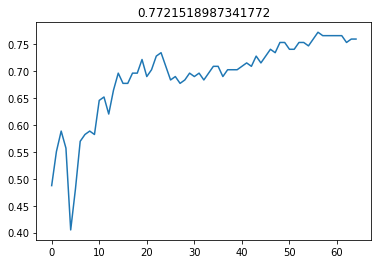

Classification report for classifier SubspaceMethod(n_subdims=65, normalize=False):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       129
           1       0.24      0.14      0.17        29

    accuracy                           0.76       158
   macro avg       0.53      0.52      0.52       158
weighted avg       0.71      0.76      0.73       158




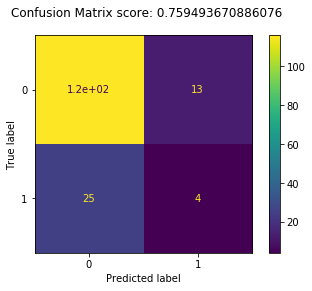

In [20]:
mn_size = len(Xv_train[y_train==1])

scores = []
for i in range(1, mn_size):
    msm = SubspaceMethod(n_subdims=i)
    msm.fit(*my_pkg.utils.format_input(Xv_train, y_train))
    scores.append(msm.score(Xv_test, y_test))
    
plt.plot(scores)
plt.title(max(scores))
plt.show()

msm.classes_ = np.unique(Y)
plot_stats(msm)

### MSM

In [21]:
mn_size = len(Xv_train[y_train==1])

scores = []
for i in range(1, test_size):
    msm = SubspaceMethod(n_subdims=i)
    msm.fit(*my_pkg.utils.format_input(Xv_train, y_train))
    scores.append(msm.score(Xv_test, y_test))
    
plt.plot(scores)
plt.title(max(scores))
plt.show()

NameError: name 'test_size' is not defined

### LDA

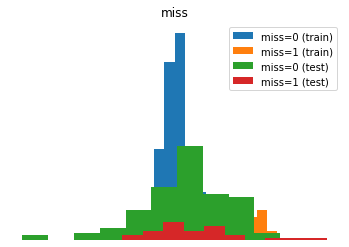

Classification report for classifier LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001):
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       129
           1       0.20      0.28      0.23        29

    accuracy                           0.66       158
   macro avg       0.51      0.51      0.50       158
weighted avg       0.71      0.66      0.68       158




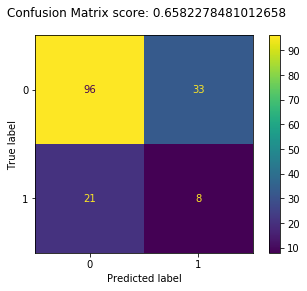

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

fig, ax = plt.subplots()

X_lda = lda.fit_transform(Xv_train, y_train)
c1 = X_lda[y_train==0]
c2 = X_lda[y_train==1]
ax.hist(c1, label=f'{dataset.label_info[0]}=0 (train)')
ax.hist(c2, label=f'{dataset.label_info[0]}=1 (train)')

X_lda = lda.transform(Xv_test)
c1 = X_lda[y_test==0]
c2 = X_lda[y_test==1]
ax.hist(c1, label=f'{dataset.label_info[0]}=0 (test)')
ax.hist(c2, label=f'{dataset.label_info[0]}=1 (test)')

ax.set_title(dataset.label_info[0])
ax.axis('off')
ax.legend()
plt.show()

plot_stats(lda)